# Проект: промышленность

Необходимо оптимизировать производственные расходы, металлургического комбината ООО «Так закаляем сталь» путем уменьшения потребления электроэнергии на этапе обработки стали. по заказу предстоит построить модель, которая предскажет температуру стали.   


***Описание этапа обработки***   
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).   


***Описание данных***  
Данные состоят из файлов, полученных из разных источников:  
data_arc_new.csv — данные об электродах;  
data_bulk_new.csv — данные о подаче сыпучих материалов (объём);  
data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);    
data_gas_new.csv — данные о продувке сплава газом;  
data_temp_new.csv — результаты измерения температуры;  
data_wire_new.csv — данные о проволочных материалах (объём);  
data_wire_time_new.csv — данные о проволочных материалах (время).  
Во всех файлах столбец key содержит номер партии.  
В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
pip install catboost

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from catboost import CatBoostRegressor

In [ ]:
data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [ ]:
def read_file(file):
    print('Структура файла:')
    display(file.info())
    print('Описательная статистика:')
    display(file.describe())
    print('Выборка данных:')
    display(file.head(2))
    display(file.tail(2))
    display(file.sample(n=5))
    print ('Количество пропусков:')
    display(file.isna().sum())

#  Изучение данных
### Данные об электродах

In [ ]:
read_file(data_arc_new)

Структура файла:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Описательная статистика:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Выборка данных:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14338,3119,2019-09-02 10:54:37,2019-09-02 10:57:05,0.494600,0.342528
1011,219,2019-05-11 19:47:52,2019-05-11 19:51:12,0.787596,0.572573
8828,1920,2019-07-19 08:31:55,2019-07-19 08:37:02,1.119344,0.884035
12058,2624,2019-08-15 05:15:15,2019-08-15 05:16:51,0.720319,0.564983
9556,2071,2019-07-26 01:48:10,2019-07-26 01:49:41,0.981749,0.722449


Количество пропусков:


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [ ]:
#узнаем сколько партий стали в датасете предложено
data_unique=data_arc_new['key'].unique()
print('Количество партий стали:',data_unique[-1])

Количество партий стали: 3241


In [ ]:
#посмотрим сколько итераций нагрева в партиях встречается
data_value = data_arc_new['key'].value_counts()

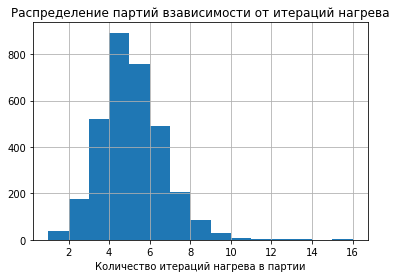

In [ ]:
data_value.hist(bins=15, grid = True)
plt.xlabel('Количество итераций нагрева в партии', fontsize=10)
plt.title('Распределение партий взависимости от итераций нагрева')
plt.show()

In [ ]:
# меняем тип данных Datetime с object на datetime64
data_arc_new = data_arc_new.astype({"Начало нагрева дугой": "datetime64", "Конец нагрева дугой": "datetime64"})

In [ ]:
# проверяем временной ряд на монотонность
print(data_arc_new.index.is_monotonic)

True


In [ ]:
# устанавливаем индекс таблицы равным столбцу Datetime
data_arc_new_time = data_arc_new.set_index('Начало нагрева дугой')

In [ ]:
# сортируем по индексам
data_arc_new_time = data_arc_new_time.sort_index(ascending = True)

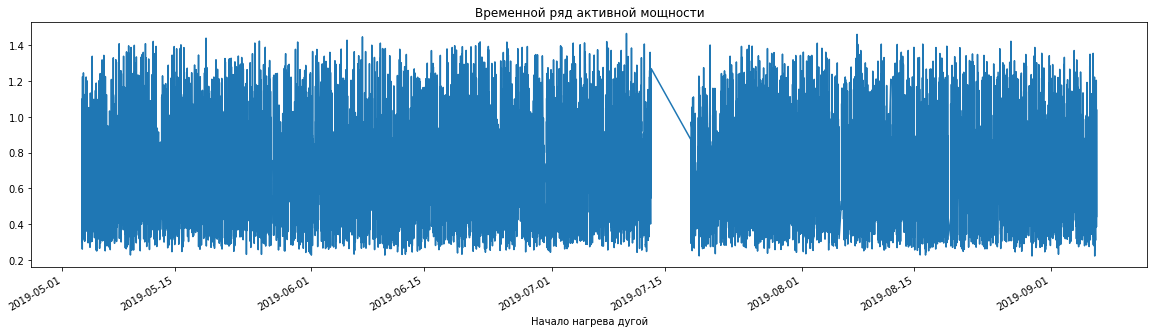

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot()
plt.title('Временной ряд активной мощности')
data_arc_new_time['Активная мощность'].plot(ax=plt.gca())
plt.show()

In [ ]:
data_arc_null = data_arc_new[data_arc_new['Реактивная мощность']<0]

In [ ]:
display(data_arc_null)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


**Кратко о данных:**   
В наборе данных представлены сведения о интервалах нагревания электродами сплава, а также мощность, которая возникает в процессе нагрева.    
**Активная мощность** — это некая часть мощности, связанная непосредственно с трансформацией в какой-либо другой вид энергии.   
**Реактивная мощность** – это та часть мощности, которая вернется в сеть обратно, это «вредоносный» процесс, который не полезен для всей системы, он характерен для устройств с нагрузкой индуктивного типа.   
**Полная мощность** рассчитывается как сумма векторов.  S = √(P² + N²).

В датасете представлены данные о 3241 процессах (партии) получения стали. Минимальное число итераций внутри одной партии 1, максимальное - 16.
На временном ряду наблюдается во второй половине июля отсутствие данных. Можно предположить о наличии либо в сбоях измерительной аппаратуры, либо остановка выплавки стали, что совсем невероятно. Если присутствуют данные за этот период в других датасетах, то эти дни данные нужно удалить, так как заполнить их корректно не получится.Встретилось одно отрицательное значение реактивной мощности, хоть мощность и может быть отрицательной, это выброс, так как присутствует в датасете в единичном экземпляре. На этапе обработки данных заменим его средним значением реактивной мощности.

### Данные о подаче сыпучих материалов (объём)

In [ ]:
read_file(data_bulk_new)

Структура файла:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Описательная статистика:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Выборка данных:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1631,1691,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,253.0,NaN,165.0,181.0
1833,1895,37.0,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,200.0,207.0
1068,1115,NaN,NaN,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,129.0,103.0
651,682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,465.0,NaN,241.0,211.0
2770,2874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,NaN,100.0,NaN


Количество пропусков:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [ ]:
#изучим количество добавок внутри каждой партии
data_bulk_new['sum_bulk']= data_bulk_new.apply(lambda row: row['Bulk 1':'Bulk 15'].count(), axis = 1)

In [ ]:
data_bulk_new.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4


In [ ]:
data_bulk_new['sum_bulk'].unique()

array([4, 3, 5, 2, 1, 6, 7])

In [ ]:
data_bulk = data_bulk_new.drop(['key'], axis=1)

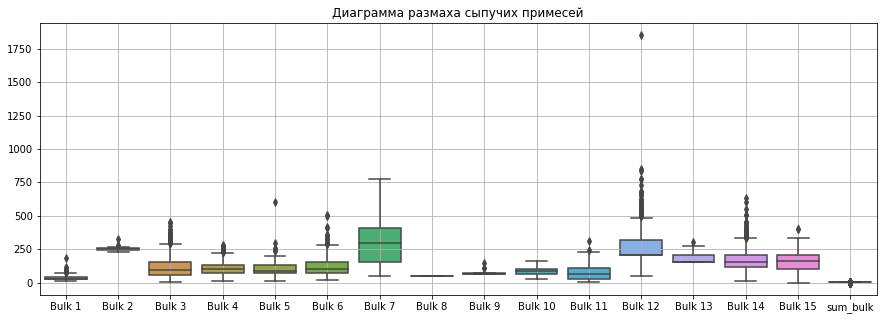

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_bulk)
plt.title('Диаграмма размаха сыпучих примесей')
plt.grid();

**Коротко о данных**   
Для получения требуемого химического состава используют 15 легирующих сыпучих материалов. В данных много пропусков, предположу, что их просто не добавляли, так как не требовалось. Поэтому пропуски заполним нулями на этапе обработки данных. Количество разных сыпучих примесей варьируется от 1 до 7 на партию. Исходя из объема пропусков можно сказать, что самой распространенной добавкой является Bulk 14, а самой менее восстребованной - Bulk 8. Данные приведены по 3129 партиям (key). Согласно диаграмме размаха наблюдаются выбросы по добавке Bulk 12, предположу, что в связи с тем, что объем добавок зависит от химического состава сплава вполне возможно, что такое значение не аномальное, а было необходимо для достижения необходимого химсостава.

### Данные о подаче сыпучих материалов (время)

In [ ]:
read_file(data_bulk_time_new)

Структура файла:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Описательная статистика:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Выборка данных:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1291,1343,NaN,NaN,NaN,2019-06-23 01:00:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,722,NaN,NaN,NaN,2019-05-31 15:45:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-31 15:45:41,NaN,2019-05-31 15:51:20,2019-05-31 15:45:41
2157,2236,NaN,NaN,NaN,NaN,NaN,2019-08-01 03:51:46,NaN,NaN,NaN,NaN,NaN,2019-08-01 03:48:57,NaN,2019-08-01 03:39:10,2019-08-01 03:33:44
703,736,NaN,NaN,NaN,2019-06-01 02:43:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-01 02:50:15,NaN,2019-06-01 02:43:17,2019-06-01 02:35:51
2841,2947,2019-08-27 12:02:50,NaN,NaN,2019-08-27 12:00:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-27 11:55:59,NaN,2019-08-27 11:49:51,2019-08-27 11:42:53


Количество пропусков:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Коротко о данных**   
Датасет отражает время ввода сыпучих материалов в сплав. С первого взгляда количество пропусков соответствует датасету об объемах.

### Данные о продувке сплава газом

In [ ]:
read_file(data_gas_new)

Структура файла:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Описательная статистика:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Выборка данных:


,key,Газ 1
0,1,29.749986
1,2,12.555561


,key,Газ 1
3237,3240,11.863103
3238,3241,12.680959


,key,Газ 1
1977,1980,14.278643
2485,2488,28.306153
3114,3117,5.066467
2548,2551,10.732997
140,141,13.428733


Количество пропусков:


key      0
Газ 1    0
dtype: int64

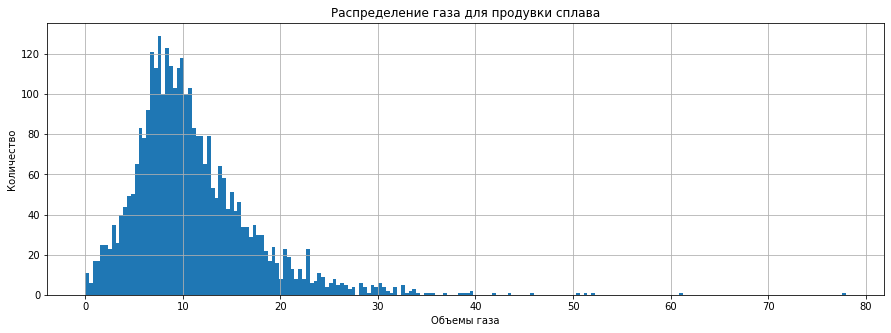

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot()
plt.title('Распределение газа для продувки сплава')
plt.xlabel('Объемы газа')
plt.ylabel('Количество')
data_gas_new['Газ 1'].hist(bins=200, grid = True)
plt.show()

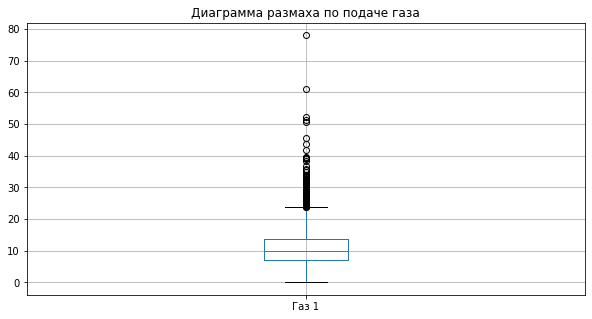

In [ ]:
plt.figure(figsize=(10, 5))
fig =data_gas_new.boxplot('Газ 1')
plt.title('Диаграмма размаха по подаче газа')
plt.show()

In [ ]:
lower_bound = data_gas_new['Газ 1'].quantile(q=0.05)
upper_bound = data_gas_new['Газ 1'].quantile(q=0.95)
n = len(data_gas_new[(data_gas_new['Газ 1'] < lower_bound) | (data_gas_new['Газ 1'] > upper_bound)])/len(data_gas_new)*100
print('Доля значений выборки, находящихся за пределами 3-сигм:', n, 'процента')

Доля значений выборки, находящихся за пределами 3-сигм: 10.00308737264588 процента


**Коротко о данных**   
Датасет информирует об объемах газа, используемого для продувки сплава. Данные агрегированы по партиям. В среднем на партию используется около 11 куб. метров газа. Пропуски отсутствуют. Данные приведены по 3239 партиям (key). 90% значений выборки находятся в промежутке 3 сигм.

### Результаты измерения температуры

In [ ]:
read_file(data_temp_new)

Структура файла:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

Описательная статистика:


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Выборка данных:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


,key,Время замера,Температура
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


,key,Время замера,Температура
12185,2173,2019-07-30 00:42:53,1578.0
2676,473,2019-05-21 13:21:35,1599.0
12920,2311,2019-08-03 15:24:07,1606.0
9784,1748,2019-07-07 07:14:11,1640.0
13267,2376,2019-08-06 06:03:13,1579.0


Количество пропусков:


key                0
Время замера       0
Температура     3427
dtype: int64

In [ ]:
col='Температура'
print('В столбце {} нулевых значений {:.1%}'. format(col, data_temp_new[col].isna().value_counts()[1] / len(data_temp_new)))

В столбце Температура нулевых значений 18.9%


In [ ]:
# посмотрим распределение средней температуры по партиям
data_temp_group = data_temp_new.groupby(['key']).mean('Температура')

In [ ]:
print(data_temp_group.head())

     Температура
key             
1    1602.166667
2    1590.600000
3    1598.166667
4    1616.800000
5    1589.000000


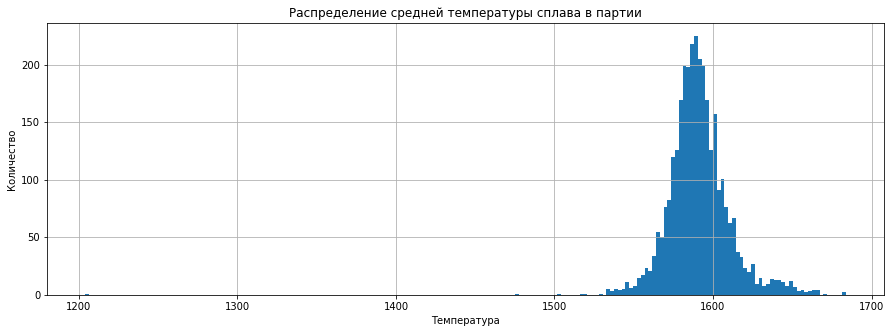

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot()
plt.title('Распределение средней температуры сплава в партии')
plt.xlabel('Температура')
plt.ylabel('Количество')
data_temp_group['Температура'].hist(bins=200, grid = True)
plt.show()

**Коротко о данных**
Датасет отражает результаты замера темпретуры сплава в процессе обогащения. в данных наблюдается 18,9% пропусков. Учитывая, что конечная температура смеси этот таргетное значение пропуски оставим без изменения и оценим их после слияния всех даннах.
По информации от заказчика температура плавления нашего металла должна быть не ниже 1500 градусов, все что ниже - аномалии, поэтому партии, в которых конечная температура ниже 1500 градусов не будем использовать в обучающих и тестовых наборах данных. Агрегируем данные по ключу. Распределение близко к нормальному.

### Данные о проволочных материалах (объём)

In [ ]:
read_file(data_wire_new)

Структура файла:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Описательная статистика:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Выборка данных:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
594,630,156.592803,118.257354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,62,97.100639,63.132160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1624,1704,80.121597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1555,1634,104.410797,58.148479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2440,2567,18.301920,NaN,96.288193,NaN,15.132,73.307526,NaN,NaN,NaN


Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [ ]:
data_wire = data_wire_new.drop(['key'],axis=1)


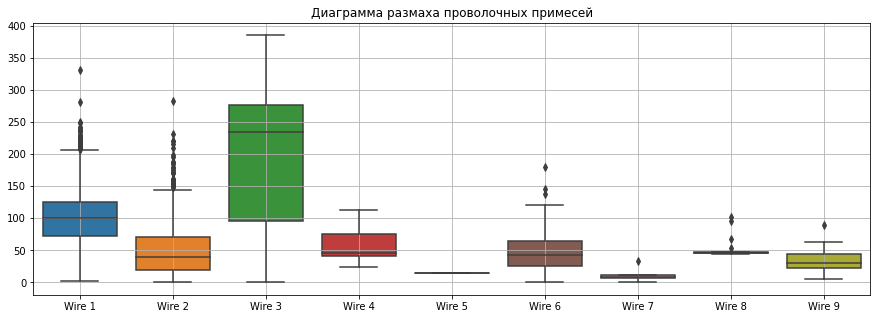

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data = data_wire)
plt.title('Диаграмма размаха проволочных примесей')
plt.grid();

**Коротко о данных**  
Данные аналогичны таблице по сыпучим материалам. Всего используется 9 видов проволочных лигирующих материалов. Пропуски обрабатываем в 0. Самая восстрабованная добавка Wire 1, за самая редкая- Wire 5.Данные приведены по 3081 партии (key). Выбросы наблюдаются по проволочным добавкам wire1 и wire2.

### Данные о проволочных материалах (время)

In [ ]:
read_file(data_wire_time_new)

Структура файла:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Описательная статистика:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Выборка данных:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1015,1075,2019-06-13 18:20:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969,2066,2019-07-25 20:14:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
710,757,2019-06-02 02:50:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2062,2160,2019-07-29 14:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
919,979,2019-06-10 06:44:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

**Коротко о данных**
Датасет отражает время ввода сыпучих материалов в сплав. Данные приведены по 3081 партии(key).

***Выводы по обзору данных***

Данные о производственном процессе присутствуют в семи таблицах. Общий обзор показал, что во всех таблицах, кроме двух ("Данные об электродах" и "Данные о температуре") данные группированы по партиям по 'key'. Всего определяется 3241 партий с разным количеством итераций (нагреваний) от 1 до 16. В данных о сыпучих продуктах и проволочных добавок встречается много пропусков. Пропуски говорят о том, что добавки не добавлялись, поэтому заменяем пропуски на "0". Во всех признаках времени нет части данных в июле. В части признаков есть выбросы - отрицательная реактивная мощность, температура ниже 1500С. Во всех таблицах количество значений key разное, нужно выбрать правильный способ объединения таблицы признаков. По условию целевой переменной, которую необходимо предсказывать является конечная температура сплава.

# План работы

1. Выполнить EDA:
    -исключить аномали, связанные с отрицательным значением мощности, значениям температур ниже 1500 градусов;
    -заменить пустые данные на "0" в датасетах про примеси.
    -привести переменные к соответствующим типам согласо их смыслу.
    -исследовать корреляцию между имеющимися признаками.
    
2. Подготовить данные для обучения модели:

    - сгенерировать новые признаки например:
        S - суммарная мощность (сумма векторов),
        t - интервал получения новой партии стали по данным о начале нагрева и окончании нагрева сплава,
        A - работа Мощность*Время нагрева,
        N - количество нагреваний (итераций) в рамках одной партии стали;
        
    - взять существующие:
        время начало награва;
        время завершения нагрева;
        объем газа;
        начальная температура;
        объем добавления сыпучих примесей (16 позиций);
        объем добавления проволочных примесей (9 позиций).
    - сформировать сводную таблицу признаков
    - сформировать обучающую и тестовую выборки (25%) для обучения модели.
     
3.Выбрать модели для обучения:   
    - RandomForestRegressor    
    - Catboost    
    - проверка лучшей модели на тестовой выборке.    
4.Подготовить отчет.

Вопросов пока нет.

# EDA и подготовка данных дляя обучения моделей

In [ ]:
def boxplot_fig (df, name, title):
    plt.figure(figsize=(10, 5))
    fig = df.boxplot(name)
    plt.title(title)
    plt.show()

In [ ]:
#Заменяем названия столбцов
data_arc_new.columns=['key','begin_heating','end_heating','active_power','ractive_power']
data_bulk_new.columns=data_bulk_new.columns.str.lower().str.replace(' ','_')
data_wire_new.columns=data_wire_new.columns.str.lower().str.replace(' ','_')
data_gas_new.columns=['key','gas_1']
data_temp_new.columns=['key','measurement_time','temperature']

In [ ]:
#Заменяем аномальное значение отрицательной реактивной мощности на среднее значение
data_arc_new.loc[data_arc_new['ractive_power']<0, 'ractive_power'] = data_arc_new['ractive_power'].mean()

In [ ]:
#Генерируем новые признаки: потребляемая мощность, количество секунд нагрева, работа
data_arc_new['sum_power'] = data_arc_new.apply(lambda row: math.sqrt(row.active_power**2+row.ractive_power**2), axis = 1)
data_arc_new['heating_time'] = data_arc_new['end_heating']-data_arc_new['begin_heating']
data_arc_new['heating_time_ss'] = data_arc_new.apply(lambda row: row.heating_time.seconds, axis = 1)
data_arc_new['work'] = data_arc_new.apply(lambda row: row.heating_time_ss*row.sum_power, axis = 1)
data_arc_new = data_arc_new.drop(['heating_time'], axis=1)

In [ ]:
#Считаем количество итераций нагрева по каждой партии, добавляем в фичи
data_arc_new_count = data_arc_new.groupby(by = 'key').count().reset_index()[['key','begin_heating']]
data_arc_new_count.columns = ['key','heating_iterations']

In [ ]:
#Суммируем значения новых фичей внутри каждой партии
data_arc_new = data_arc_new.groupby(by = 'key').sum()
data_arc_new.head()

,active_power,ractive_power,sum_power,heating_time_ss,work
key,,,,,
1,3.036730,2.142821,3.718736,1098,770.282114
2,2.139408,1.453357,2.588349,811,481.760005
3,4.063641,2.937457,5.019223,655,722.837668
4,2.706489,2.056992,3.400038,741,683.455597
5,2.252950,1.687991,2.816980,869,512.169934


In [ ]:
#Проводим замену пустых значений в датасетах с присадками (сыпучими и проволочными) на "0"
data_bulk_new = data_bulk_new[['key','bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                               'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']].fillna(0)
data_wire_new = data_wire_new[['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7',
                               'wire_8','wire_9']].fillna(0)
display(data_bulk_new.head())
display(data_wire_new.head())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Удаляем строки с отсутствующими данными о температуре и те, где есть в партии температура меньше 1500 градусов
data_temp = data_temp_new[(data_temp_new['temperature']<=1500)|(data_temp_new['temperature']=='NaN')]
data_temp = data_temp.set_index('key')
index_list = data_temp.index.values.tolist ()
index_list

[867, 1214, 1619, 2052, 2561]

In [2]:
#Удаляем партии с температурой меньше 1500 градусов и те где не было изменений вообще.
for i in range(len(index_list)):
    data_temp_new = data_temp_new[data_temp_new['key']!=index_list[i]]

In [ ]:
#Считаем количество измерений температуры по каждой партии
data_temp_new_count = data_temp_new.groupby(by = 'key').count().reset_index()[['key','temperature']]
data_temp_new_count.columns = ['key','temperature_iterations']

In [ ]:
#Удаляем строки те, что имеют одно изменение температуры
data_temp_new_count = data_temp_new_count[data_temp_new_count['temperature_iterations'] != 1 ]

In [3]:
data_temp_new_count.tail()

In [ ]:
# Извлекаем первоначальную и конечную температуру сплава
data_temperature = {'temperature': ['first', 'last']}
df_temperature = data_temp_new.sort_values(by=['measurement_time'], ascending=True).groupby(['key']).agg(data_temperature)
df_temperature.columns = df_temperature.columns.droplevel()
df_temperature.columns = ['temperature_first','temperature_last']

In [7]:
df_temperature.tail()

In [ ]:
#Объединяем данные в один датафрейм
data=data_arc_new.merge(data_arc_new_count, how='inner', on='key').merge(data_bulk_new,how='inner', on='key').\
                  merge(data_wire_new,how='inner', on='key').merge(data_gas_new,how='inner', on='key').\
                  merge(data_temp_new_count,how='inner', on='key').merge(df_temperature,how='inner', on='key')

<AxesSubplot:>

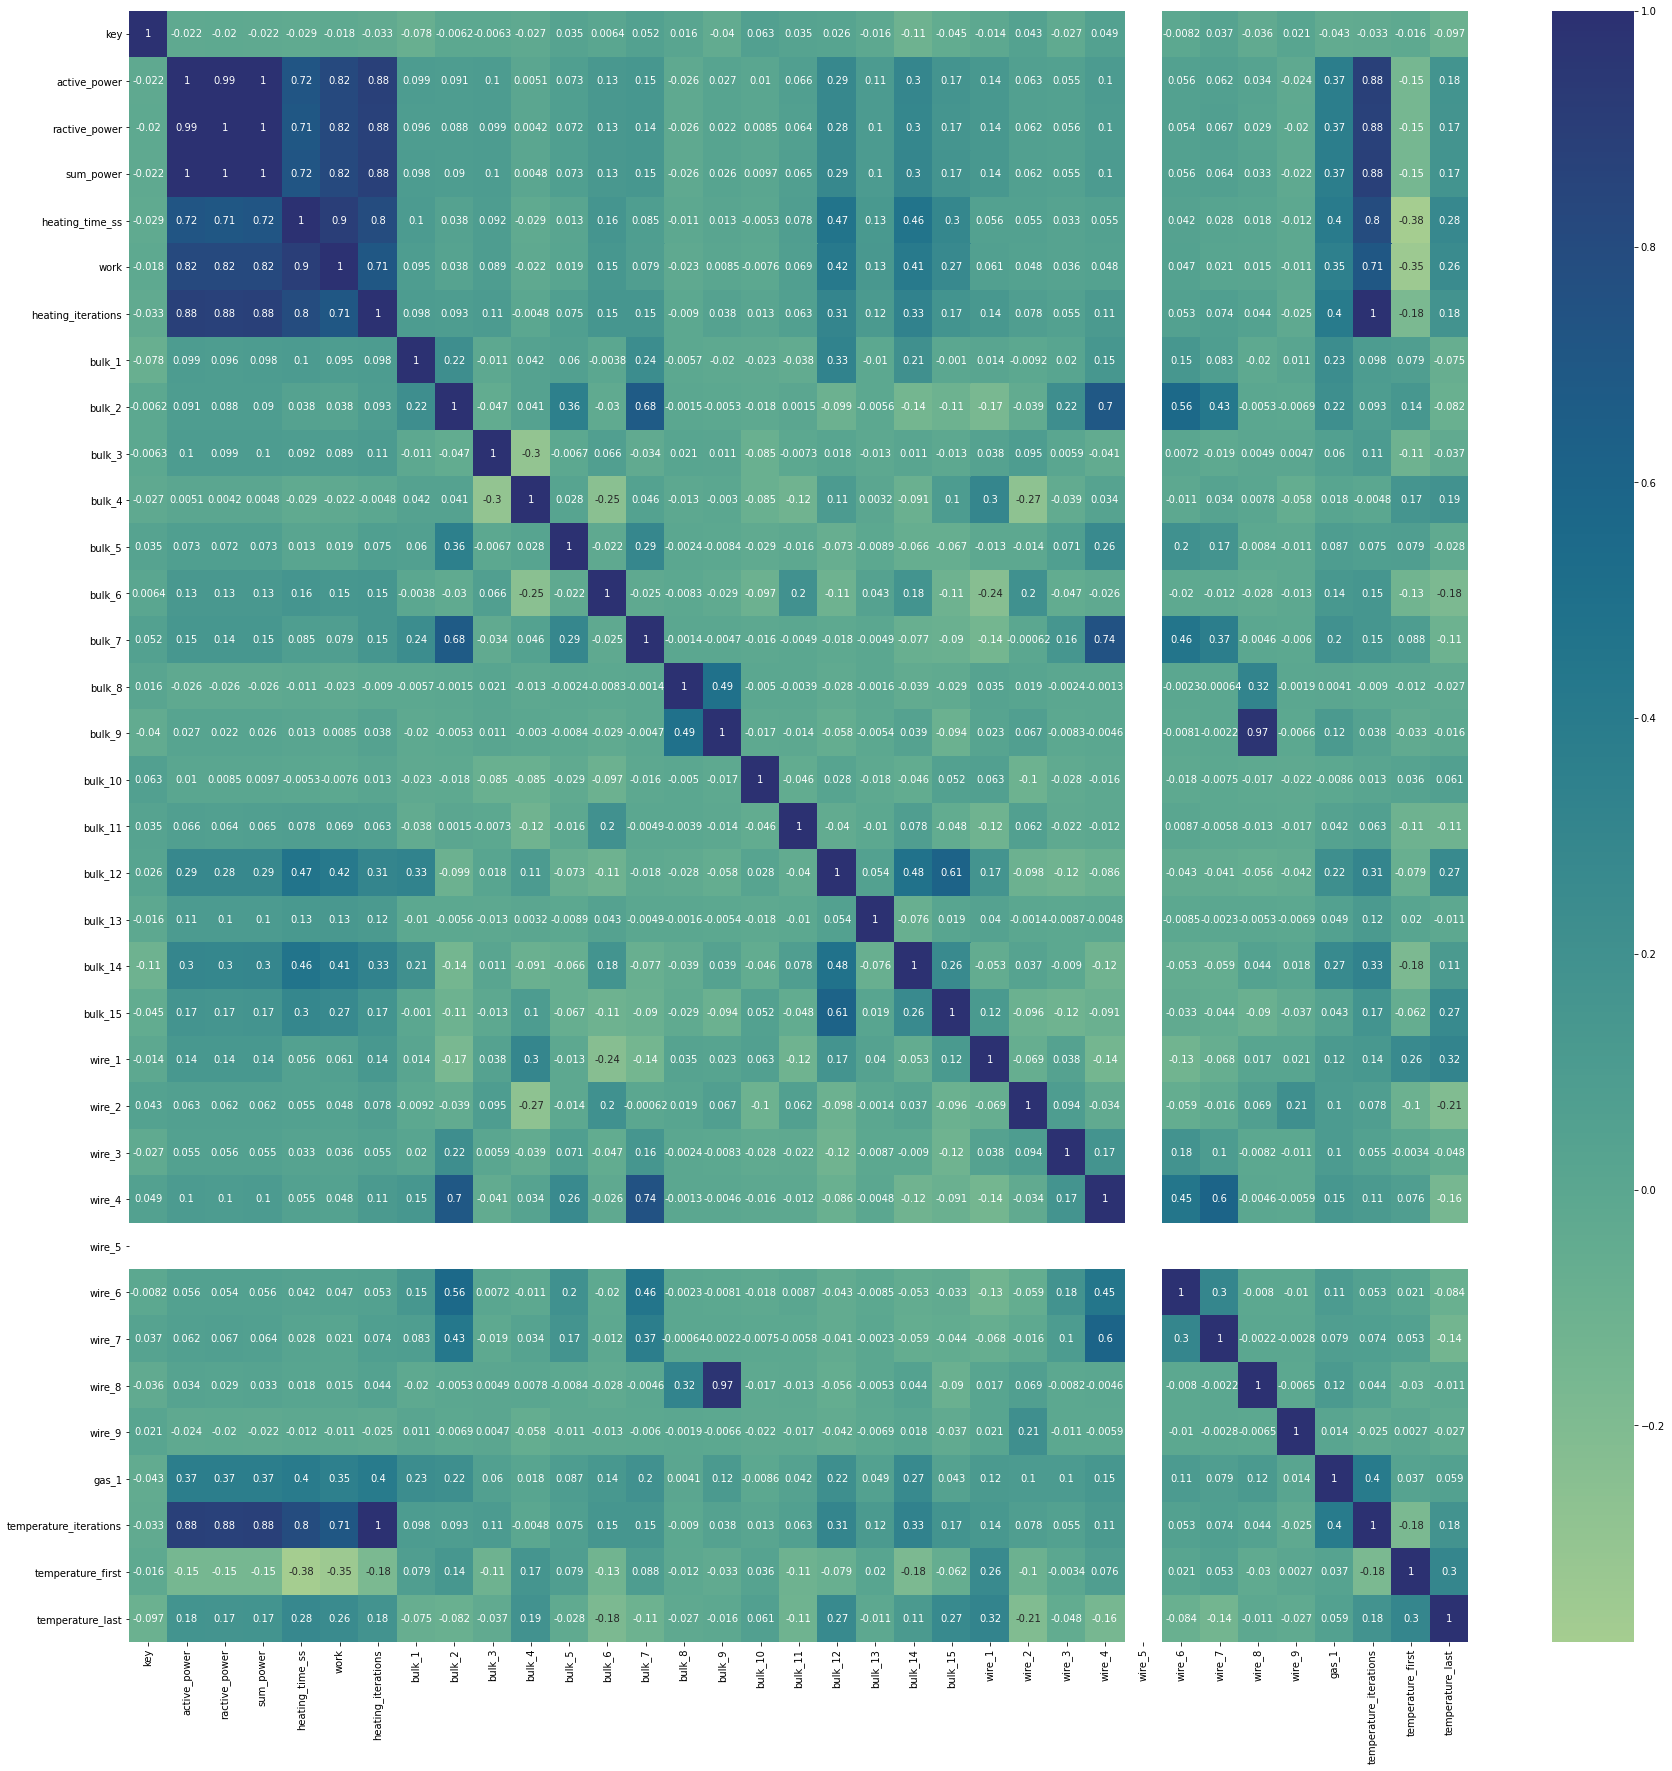

In [ ]:
# Исследуем корреляцию
plt.figure(figsize=(30,30))
sns.heatmap(data.corr(),cmap="crest", annot=True)

Согласно тепловой карте наблюдается сильная корреляция между признаками, связанные с мощностью. поэтому выберу суммарную мощность, удалив активную и реактивную. Также есть высокая корреляция между сыпучей присадкой bulk_9 и wire_8, есть предположения, что эти добавки в сплав добавляются одновременно, поэтому наблюдается сильная корреляция.

In [ ]:
#Уберем сильно зависимые признаки
data =data.drop(['active_power','ractive_power','key','heating_iterations','temperature_iterations','wire_5','wire_8'],axis=1)
data.tail()

,sum_power,heating_time_ss,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,gas_1,temperature_first,temperature_last
2320,3.868721,723,694.177326,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,7.125735,1570.0,1591.0
2321,5.070316,940,815.818538,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,9.412616,1554.0,1591.0
2322,4.360918,569,823.020520,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,6.271699,1571.0,1589.0
2323,3.909917,750,581.810739,0.0,0.0,90.0,0.0,0.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,14.953657,1591.0,1594.0
2324,2.169252,883,532.386183,0.0,0.0,47.0,0.0,0.0,0.0,0.0,...,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,11.336151,1569.0,1603.0


<AxesSubplot:>

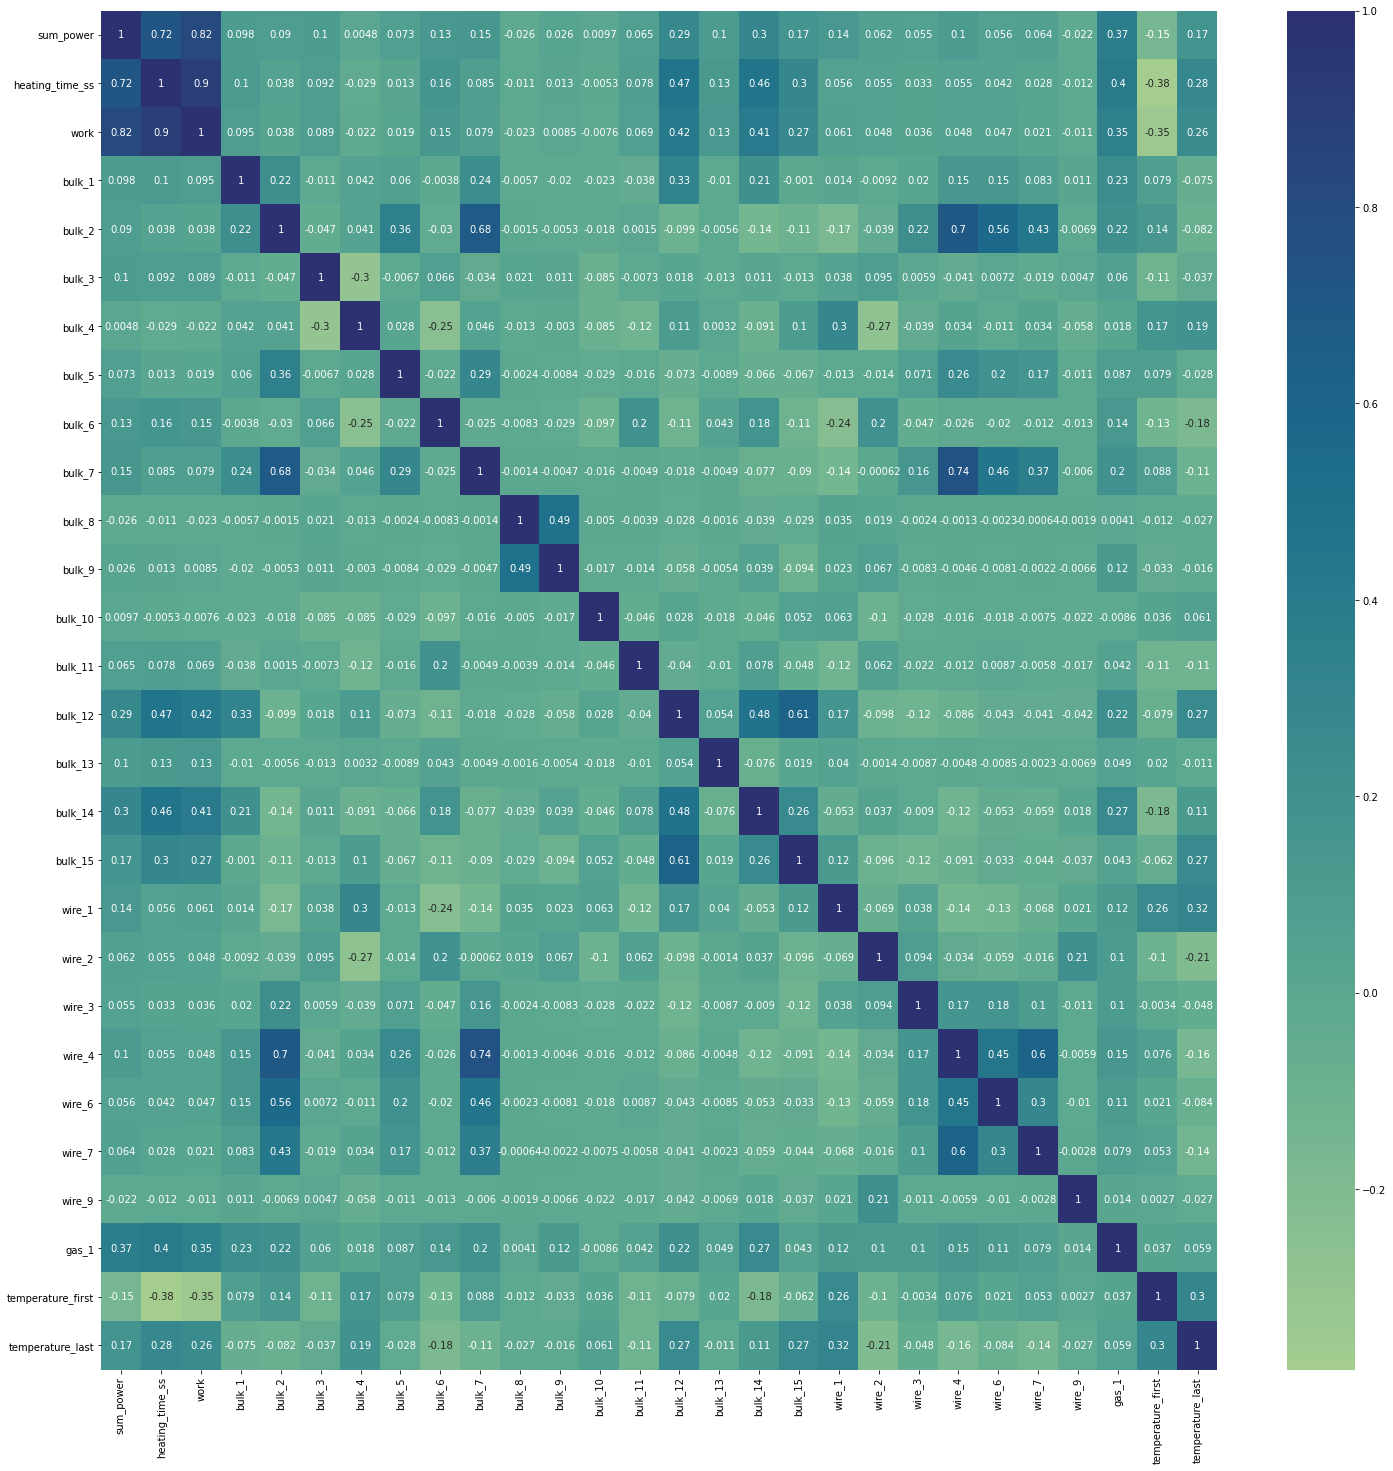

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr(),cmap="crest", annot=True)

In [ ]:
#Исследуем влияние признаков на целевую переменную и визуализируем
corr_data=pd.Series(dtype='float64')
for col in data.columns:
    corr_data[col] = data['temperature_last'].corr(data[col])
corr_data= corr_data.sort_values(ascending=False)[1:]

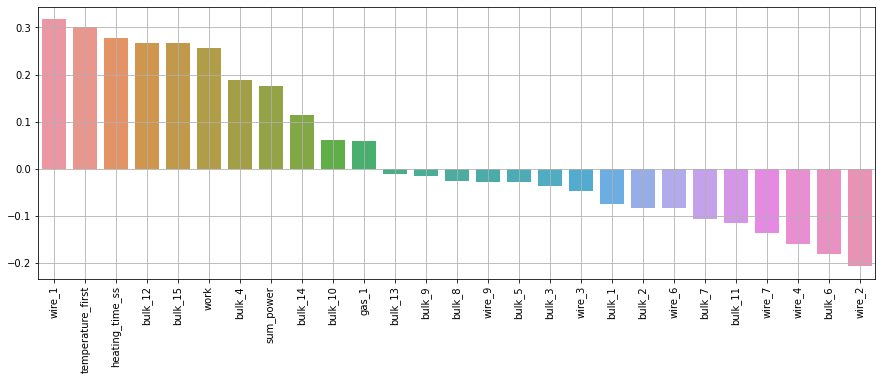

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x=corr_data.index, y=corr_data.values)
plt.grid()
plt.xticks(rotation=90)
plt.show();

**Вывод**  

1.Названия столбцом приведены к "змеиному виду"   
2.Аномальное значение отрицательной реактивной мощности заменено на среднее значение   
3.Сгенерированы новые признаки: потребляемая мощность, количество секунд нагрева, работа, количество итераций нагрева, количество измерения температуры   
4.Проведена агрегация по партиям в датафреймах об электродах и температурах сплава   
5.Проведена замена пустых значений в датасетах с присадками (сыпучими и проволочными) на "0"   
6.Удалены строки с отсутствующими данными о температуре и с температурой меньше 1500 градусов   
7.Удалены партии, что имеют одно измерение температуры   
8.Сформирован признак начальной температуры и таргетная перепенная с данными конечной температуры сплава   
9.Сформирован итоговый дата сет с 2325 строками и с 26 признаками и целевой переменной   
10.Построена матрица корреляции, определена зависимость признаков на целевую переменную. На целевую переменную - конечную температуру влияет проволочная добавка wire_1, на втором месте находятся первоначальная температура, отрицательная зависимость наблюдается с рядом других присадок (bulk_6, wire_2). Полная мощность влияет на конечную температуру на более 20 процентов.  


# Обучение моделей

In [ ]:
RANDOM_STATE = 12923

In [ ]:
# Формируем обучающую выборку
train, test = train_test_split(data, test_size=0.25,random_state=RANDOM_STATE)
features_train = train.drop(['temperature_last'],axis=1)
target_train = train['temperature_last']
features_test = test.drop(['temperature_last'],axis=1)
target_test = test['temperature_last']

In [ ]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1743, 27)
(1743,)
(582, 27)
(582,)


**LinearRegression**

In [ ]:
%%time
pipe = Pipeline(steps=[('scaler', StandardScaler()),('model', LinearRegression())])

parameters = {'model__fit_intercept':[True,False],
              'model__n_jobs':[-1,1]}

seach_LR = GridSearchCV(pipe, param_grid=parameters, cv=5,scoring='neg_mean_absolute_error')
seach_LR.fit(features_train, target_train)

print('Итоговое MAE для линейной регрессии:', -1*seach_LR.best_score_)
print('Лучшие параметры модели: ', seach_LR.best_params_)

Итоговое MAE для линейной регрессии: 6.260584863782488
Лучшие параметры модели:  {'model__fit_intercept': True, 'model__n_jobs': -1}
CPU times: user 624 ms, sys: 1.01 s, total: 1.63 s
Wall time: 1.59 s


**DecisionTreeRegressor**

In [ ]:
%%time
pipe = Pipeline(steps=[('scaler', StandardScaler()),('model', DecisionTreeRegressor())])

param = {'model__max_depth': range(1,10),
         'model__min_samples_leaf': range (1,5)}

seach_DTR= GridSearchCV(pipe, param, cv=5,scoring='neg_mean_absolute_error')
seach_DTR.fit(features_train, target_train)
print('Лучшие параметры модели: ', seach_DTR.best_params_)
print('Итоговое MAE для случайного леса:', -1*seach_DTR.best_score_)

Лучшие параметры модели:  {'model__max_depth': 6, 'model__min_samples_leaf': 2}
Итоговое MAE для случайного леса: 7.145664890040798
CPU times: user 2.6 s, sys: 42.5 ms, total: 2.65 s
Wall time: 2.67 s


**RandomForestRegressor**

In [ ]:
%%time
pipe = Pipeline(steps=[('scaler', StandardScaler()),('model', RandomForestRegressor())])

param = {'model__n_estimators':[70,100,150,200],
         'model__max_features':[0.1,0.3,1]}

seach_RFR= GridSearchCV(pipe, param, cv=5,scoring='neg_mean_absolute_error')
seach_RFR.fit(features_train, target_train)
print('Лучшие параметры модели: ', seach_RFR.best_params_)
print('Итоговое MAE для случайного леса:', -1*seach_RFR.best_score_)

Лучшие параметры модели:  {'model__max_features': 0.3, 'model__n_estimators': 150}
Итоговое MAE для случайного леса: 6.341426659640571
CPU times: user 25 s, sys: 150 ms, total: 25.2 s
Wall time: 25.5 s


**CatBoostRegressor**

In [5]:
parameter = {'learning_rate': [0.03,0.1],
             'depth': [2,4,6,8],
             'l2_leaf_reg': [1,2,3]
}
model = CatBoostRegressor()
search_CBR = GridSearchCV(estimator = model, param_grid = parameter, cv = 5, n_jobs=-1, scoring='neg_mean_absolute_error')
search_CBR.fit(features_train, target_train)


In [ ]:
print('Итоговое MAE для Catboost:', -1*search_CBR.best_score_)
print('Лучшие параметры модели: ',search_CBR.best_params_)

Итоговое MAE для Catboost: 6.110696985279313
Лучшие параметры модели:  {'depth': 4, 'l2_leaf_reg': 2, 'learning_rate': 0.03}


In [ ]:
#проверка на тестовой выборке
pred = search_CBR.predict(features_test)
MAE_final = mean_absolute_error(target_test, pred)
print('MAE на тестовой выборке - ', MAE_final)

MAE на тестовой выборке -  6.265668534935993


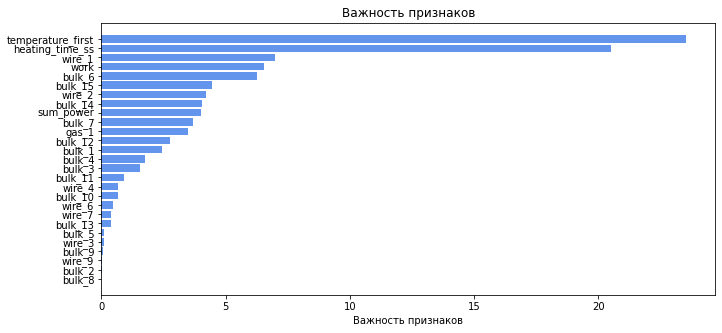

,Важность признаков
temperature_first,23.536620
heating_time_ss,20.502408
wire_1,6.969021
work,6.534779
bulk_6,6.247332
bulk_15,4.457451
wire_2,4.200559
bulk_14,4.046539
sum_power,4.005289
bulk_7,3.694241


In [ ]:
features=features_test.columns
importances = search_CBR.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(11, 5))
plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Важность признаков')
plt.show()

feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
feat_importances = feat_importances.to_frame()
feat_importances.columns=['Важность признаков']
display(feat_importances)

**Выводы**  
Подготовлены обучающая и тестовая выборки в соотвношении 75:25. Обучение проведено с использованием четырех моделей: LinearRegression, RandomForestRegressor, DecisionTreeRegressor,  CatBoostRegressor с использованием заданной метрики качества.  Лучший результат MAE = 6.11 получен на обучающей выборке моделью CatBoostRegressor. На тестовой выборке получен результат MAE=6,26. Сделана визуализация важности признаков. На величину конечной температуры влияют прежде всего первичная температура и время нагревания (это очень логично), далее фактически в два раза уменьшается важность добавленных присадок.

# Отчет по проекту

*Какие пункты плана были выполнены, а какие — нет. Почему?*  
*Какие трудности возникли и как вы их преодолели?*  
*Какие ключевые шаги в решении задачи вы выделили?*  
*Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?*  
*Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?*  

    В ходе реализации проекта итоговое решение отличается от первоначального плана действия. Отличие заключается в формировании итоговых признаков, влияющих на конечную температуру стали. В результате решения в итоговый датасет не вошли временные (datatime) признаки, такие как начало нагрева и окончание нагрева партии стали, но были использованы для расчета новых признаков, таких как время нагрева, рассчитанное как разница между началом и окончанием нагрева, количество замеров температуры. В датасете о температурном режиме временные характеристики были использованы для определения первоначальной и конечной температуры стали. Датасеты о времени добавления примесей не были использованы в предсказании конечной температуры в связи их неинформативностью для оценки конечной температуры.
    Причины расхождения планируемых признаков с фактическими связаны с недостаточным изучением данных на этапе ознакомления с датасетами. Необходимо глубже проводить анализ данных.
    
    Трудности возникли с определением количества признаков и их выбором по сути.
    Для достижения необходимой метрики cформировала датасеты с разным количеством признаков, и проверяла на всех моделях. Например, при исключении признаков с присадками, которые в малочисленном количестве добавлялись в сплав, результат по метрике не соответствовал заданным параметрам. Присадки определяют марку стали, поэтому из обучающего датасета нецелесообразно их убирать воизбежание получения недостоверных данных на тесте.
    
    После формирования рассчитываемых характеристик (признаков) проведена оценка корреляции между 36 признаками, в результате была выявлена сильная корреляция между следующими признаками:
    - активная мощность
    – реактивная мощность
    – суммарная мощность
    – время нагревания
    - работа
    - количество нагреваний внутри одной партии
    
    В результате из расчетных характеристик выбрала суммарную мощность, работу, удалила активную и реактивную мощность, количество нагреваний внутри одной партии. А также 2 проволочные примеси, по одной из которых wire_5 после сборки датасета информация отсутствовала и wire_8, которая сильно коррелировала с bulk_9.
    В итоговый датасет вошли 2325 строки, ограниченные 2499 партией. Записи по более поздним партиям не содержали необходимое количество замеров температуры. 5 партий имели начальную температуру ниже 1500 градусов и тоже были удалены из итогового датасета.
   
    Ключевыми шагами в решении задачи стали:
    1. Ознакомление с технологическим процессом выплавки стали;
    2. Исследование данных, сопоставление по времени разных процессов, поиск аномалий и их исключение, выбор способа замены пропусков;
    3. Формировнаие фичей, и определение из них значимых;
    4. Исследование корреляции и принятие окончательного решения о наборе данных для обучения;
    5. Получение итогового датасета путем соединения обработанных датасетов, агрегированных по ключу партии, в отношении партий сведения о которых находятся во всех датасетах ("inner").
    6. Разделение обучающей и тестовой выборки 75/25.
    5. Выбор оптимальной модели для обучения, определение параметров лучшей модели;
    6. Подготовки заключительного отчета и рекомендаций заказчику.
    
     В отношении оценки моделей, нужно сказать, что в итоге было опробовано 4 модели обучения: LinearRegression, DecisionTreeRegressor,  RandomForestRegressor, CatBoostRegressor. Данные масштабированы StandardScaler(). Лучшая модель подбиралась с использованием GridsearchCV.
     
     Лучшие результаты метрики MAE явилась модель Catboost с параметрами "глубина" : 2, "регуляризация модели": 1, "шаг градиентного спуска": 0.03 и МАЕ на обучающей выборке составило 6.26. (Сравнительная таблица приведена ниже).

In [ ]:
table_of_MAE=[]
table_of_model=[]

In [ ]:
table_of_model.append ('seach_LR')
table_of_model.append ('seach_DTR')
table_of_model.append ('seach_RFR')
table_of_model.append ('search_CBR')
table_of_MAE.append(-1*seach_LR.best_score_)
table_of_MAE.append(-1*seach_DTR.best_score_)
table_of_MAE.append(-1*seach_RFR.best_score_)
table_of_MAE.append(-1*search_CBR.best_score_)

In [ ]:
models = (pd.DataFrame(
    {'Model':table_of_model,'MAE':table_of_MAE})
                .sort_values(by='MAE')
                .set_index('Model'))

models

,MAE
Model,
search_CBR,6.110697
seach_LR,6.260585
seach_RFR,6.341427
seach_DTR,7.145665


Согласно матрице важности признаков следует отметить, что конечная температура стали зависит от начальной температуры и времени нагревания, а также от одной из самых часто добавляемых проволочных присадок ware_1.  
    Согласно теории из физики,чтобы правильно вести процесс плавки необходимо знать режимы нагрева. Под режимом нагрева понимают определенные правила, порядок и способы нагрева металла, обеспечивающие температуры и скорость, которые необходимы для получения заготовок, пригодных для различных целей применения металла.  
    Температура ковки и плавки для различных марок сталей не одинакова и зависит от их химического состава. Для углеродистых сталей нагрев их определяется наличием углерода, т. е. чем больше углерода в стали, тем ниже температура плавления и ковки.  
    Учитывая большое количество разных примесей в датасетах предположу, что данные, представленные для анализа, неоднородны с точки зрения получения разных марок стали. Для получения лучших результатов при предсказании конечной температуры рекомендовала бы разделить данных о процессах получения разных марок стали в зависимости от добавляемых примесей в разные датасеты, потому что температурный режим получения разных марок стали разный. В качестве фича надо попробовать рассчитать скорость нагрева, которая зависит от присадок, добавляемых в сплав.
    В эксплуатацию рекомендую модель Castboost.